## 0. Introduction

The aim of this lab is to get familiar with **Neural Networks**. We will be using some code extracts that were implemented on the week 4 Classification I lab and build a Neural Network.

1.   This lab is part of Assignment 1 part 2.
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebooks.
3. A single pdf report should be submitted on QMplus along with the completed Notebooks **for both** this and the Classification I notebook (lab 4).
4. The deadline for **both** is **Friday, 17 November 11:59pm**
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
8. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

## 0.1 Intro to Neural Networks

As covered in the lecture notes, Neural Networks (NN) are inspired by biological brains. Each "neuron" does a very simple calculation, however collectively they can do powerful computations.

A simple model neuron is called a Perceptron and is comprised of three components:
1. The weights
2. The input function
3. The activation function

perceptron.png

We can re-imagine the logistic regression unit as a neuron (function) that multiplies the input by the parameters (weights) and squashes the resulting sum through the sigmoid.

A Feed Forward NN will be a connected set of logistic regression units, arranged in layers. Each unit’s output is a non-linear function (e.g., sigmoid, step function) of a linear combination of its inputs.
nn.svg

We will use the sigmoid as an activation function. Add the sigmoid function and `LogisticRegression` class from week 4 lab below.
Change the parameter initialization in `LogisticRegression`, so that a random set of initial weights is used.



<u><font color="maroon">**Q1.** Why is it important to use a random set of initial weights rather than initializing all weights as zero in a Neural Network? [2 marks] </font></u>


In [193]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

torch.manual_seed(0)

In [194]:
## sigmoid
def sigmoid(z: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-z))

In [195]:
## logistic regression class
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(num_features, 1), requires_grad=True)

  def forward(self, x):
    # Performing the weighted sum of inputs and weights
    logits = torch.mm(x, self.weight)
    # Applying the sigmoid function to the weighted sum
    y = sigmoid(logits)
    return y

# 1. The XOR problem

Let's revisit the XOR problem.

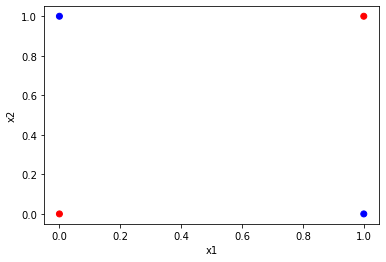

In [196]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<u><font color="maroon"> **Q2.** How does a NN solve the XOR problem? [1 marks]</font></u>


We will implement back-propagation on a Feed Forward network to solve the XOR problem. The nework will have 2 inputs, 2 hidden neurons and one output neuron. The architecture is visualised as follows:

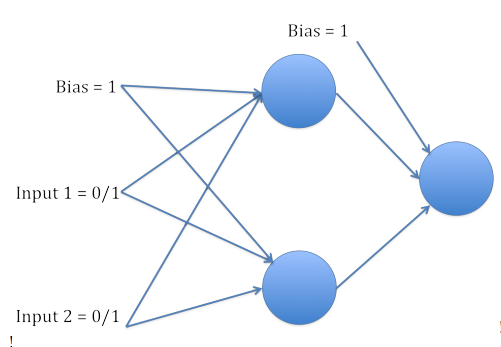

Using `LogisticRegression` and `sigmoid` from week 4 lab, implement the forward pass in the class below. Assume a single sample at a time (i.e. the shape of `x` is `(1, num_features`)). [2 marks]

Hint: Check `ModuleList` [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html).

In [197]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_neurons, num_outputs):
        super().__init__()
        self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs) for i in range(num_neurons)])
        self.output_layer = nn.ModuleList([LogisticRegression(num_neurons+1) for i in range(num_outputs)]) # +1 for the bias

    def forward(self, x: torch.tensor) -> torch.tensor:
        # Ensuring x is a 2D tensor for matrix multiplication in LogisticRegression
        x = x.reshape(1, -1)  # Reshaping x to [1, num_features]

        # Processing input through hidden layer neurons and collect outputs
        y_hidden = [neuron(x).item() for neuron in self.hidden_layer]
        y_hidden.append(1)  # Adding the bias term
        self.hidden_layer_output = torch.tensor(y_hidden).reshape(1, -1)  # Storing the hidden layer output

        # Processing through the output layer
        y_output = torch.cat([neuron(self.hidden_layer_output) for neuron in self.output_layer], dim=1)

        return y_output


    def backward_pass(self, x: torch.tensor, y: torch.tensor, lr: float) -> None:
        # Forward pass to get the outputs (for computing gradients)
        self.forward(x)

        # Calculating the output layer error and gradients
        output_errors = []
        for idx, neuron in enumerate(self.output_layer):
            y_pred = neuron(self.hidden_layer_output)
            error = y_pred - y[idx].reshape(-1, 1)  # Adjusting the indexing of y
            derivative = y_pred * (1 - y_pred)  # applying the derivative
            output_errors.append(error * derivative)

        # Calculating the hidden layer error
        hidden_errors = []
        for j, hidden_neuron in enumerate(self.hidden_layer):
            error = sum(neuron.weight[j].item() * output_errors[k] for k, neuron in enumerate(self.output_layer))
            hidden_errors.append(error * self.hidden_layer_output[0, j] * (1 - self.hidden_layer_output[0, j]))  # sigmoid derivative

        # Updating the output layer weights
        for k, neuron in enumerate(self.output_layer):
            for j in range(len(self.hidden_layer_output[0])):
                neuron.weight[j].data -= lr * output_errors[k].item() * self.hidden_layer_output[0, j]

        # Updating the hidden layer weights
        for j, neuron in enumerate(self.hidden_layer):
            for i in range(x.size(0)):
                # Ensuring the operation is element-wise and tensors are 1D
                weight_update = lr * hidden_errors[j].item() * x[i].item()
                neuron.weight[i].data -= weight_update

In [198]:
# test it works!!
x_test = torch.tensor([0., 0., 1.]) # last value is the bias
y_test = torch.tensor([0.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
print(model(x_test))
print(model)
for name, param in model.named_parameters():
  print(name, param)

print('\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

tensor([[0.5000]], grad_fn=<CatBackward0>)
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0-1): 2 x LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
  )
)
hidden_layer.0.weight Parameter containing:
tensor([[0.],
        [0.],
        [0.]], requires_grad=True)
hidden_layer.1.weight Parameter containing:
tensor([[0.],
        [0.],
        [0.]], requires_grad=True)
output_layer.0.weight Parameter containing:
tensor([[0.],
        [0.],
        [0.]], requires_grad=True)

Hidden layer weight matrix:
tensor([[[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]]], grad_fn=<StackBackward0>)


In the `NeuralNetwork` class above, fill in the `backward_pass()` method.

The implementation should support outputs of any size. To implement the backward pass, follow the steps below:



*   **Step 1:** For each output, $k$, calculate the partial derivative: $\delta_{k} = (y_{k}-t_{k}) \times g'(x_{k})$ \\
where $y_{k}$ is the response of the output neuron and $t_{k}$ is the desired output (target). The derivative of the sigmoid function $g'(x_{k})$ is defined as $g'(x_{k}) = g(x_{k}) × (1 - g(x_{k}))$ [1 marks]
*  **Step 2:** We now need to probagate this error to the hidden neurons. To accomplish this remember that: $$
 \delta_{j} = g^\prime(x_{j}) \sum_{k} w_{jk} \delta_{k}
$$  where $\delta_{j}$ is the error on the j-th hidden neuron,$x_{j}$ is the value of the hidden neuron (before it has been passed through the sigmoid function), $g^\prime$ is the derivative of the sigmoid function, $\delta_{k}$ is the error from the output neuron calculated in step 1, and $w_{jk}$ is the weight from the hidden neuron $j$ to the output neuron $k$. [1 marks]

* **Step 3:** We now need to update the output weights, i.e. the connections from the hidden neurons to the output neurons. This is accomplished using the formula: $$
 w_{jk} = w_{jk} - \eta \delta_{k} \alpha_{j}
$$ where $w_{jk}$ is the weight connecting the j-th hidden neuron to the k-th output neuron. $\alpha_{j}$ is the activity of the j-th hidden neuron (after it has been transformed by the sigmoid function), $\delta_{k}$ is the error from the output neuron stored in output\_deltas and $\eta$ is the learning rate [1 mark]

* **Step 4:**  Finally we need to update the hidden weights, i.e. the connections from the hidden neurons to the inputs. Here, again we use this equation $$
 w_{ij} = w_{ij} - \eta \delta_{j} x_{i}
$$ where $w_{ij}$ is the weight connecting the i-th input to the j-th hidden neuron. $x_{i}$ is the i-th input, $\delta_{j}$ is the backpropagated error (i.e., hidden deltas) from the j-th hidden neuron and $\eta$ is the learning rate. [1 mark]



In [199]:
# test it works
model.backward_pass(x_test, y_test, 1)

Now modify the code below to train a model on the XOR problem. Make sure to use an appropriate lr and number of iterations. Use the BCE method from week 4 to visualize cost. [1 mark]

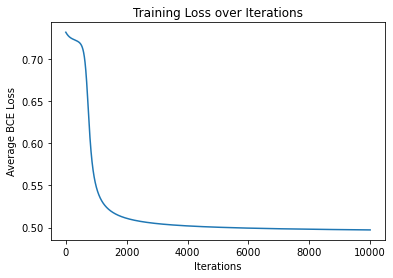

Ground Truth: tensor([0., 1., 1., 0.])
Predictions:  tensor([0.0163, 0.6602, 0.6602, 0.6611])


In [200]:
# Defining the BCE loss function from week 4
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    cross_entropy_loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return cross_entropy_loss

# XOR input and output
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)
y = torch.tensor([0., 1., 1., 0.])

# Hyperparameters
lr = 0.8  # Adjusting the learning rate
iterations = 10000  # Increasing the number of iterations for better training

# Initialize the model
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)

# Training loop
errors = []
for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):
        y_pred = model(x[i])
        error += bce(y[i].reshape(1, 1), y_pred)  # Reshaping y[i] to match y_pred shape
        model.backward_pass(x[i], y[i].reshape(1, 1), lr)  # Reshaping for backward pass
    errors.append(error.item() / x.shape[0])

# Plotting the errors
plt.plot(range(iterations), errors)
plt.xlabel('Iterations')
plt.ylabel('Average BCE Loss')
plt.title('Training Loss over Iterations')
plt.show()

# Displaying the Predictions
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i]).item()

print("Ground Truth:", y)
print("Predictions: ", y_pred)

# 2. Iris Dataset
We will now use pytorch built-in methods to create an MLP classifier for the iris dataset.

In [214]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Split the data to train and test sets (make sure the same random seed is used as previously) and normalize using the method from week 4. We will use all attributes in this lab. [2 marks]

In [219]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data, 
    iris.target, 
    test_size=0.2, 
    random_state=42
)

# Normalizing the data (assuming standard normalization)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Converting to PyTorch tensors
x_train = torch.tensor(X_train).float()
x_test = torch.tensor(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

Using pytorch built in methods (and using the training loop from week 4 as guideline for the train loop), build an MLP with one hidden layer. Train the network multiple times for the following number of hidden neurons `{1, 2, 4, 8, 16, 32}`.

<u><font color="maroon"> **Q3.** Explain the performance of the different networks on the training and test sets. How does it compare to the logistic regression example? Make sure that the data you are refering to is clearly presented and appropriately labeled in the report. [8 marks]</font></u>

In [220]:
# Defining the MLP class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Training loop function from week 4
def train(model, x, y, alpha, epochs=1000):
    cost_lst = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=alpha)

    for it in range(epochs):
        optimizer.zero_grad()
        prediction = model(x)
        cost = criterion(prediction, y.view(-1))
        cost_lst.append(cost.item())
        cost.backward()
        optimizer.step()

# Function to calculate the accuracy of the model
def calculate_accuracy(model, inputs, labels):
    with torch.no_grad():  # Disabling gradient calculations for efficiency
        # Getting model predictions
        predictions = model(inputs)
        # Finding the class with the highest probability
        _, predicted_labels = torch.max(predictions, dim=1)
        # Counting how many predictions match the true labels
        correct_predictions = (predicted_labels == labels.squeeze()).sum().item()
        # Calculating the accuracy as a ratio of correct predictions to total samples
        accuracy = correct_predictions / labels.size(0)
    return accuracy

# Training and evaluating the model for different sizes of the hidden layer
hidden_sizes = [1, 2, 4, 8, 16, 32]
for hidden_size in hidden_sizes:
    # Creating an MLP model instance with the current hidden layer size
    model = MLP(input_size=4, hidden_size=hidden_size, num_classes=3)
    # Training the model
    train(model, x_train, y_train, alpha=0.2)
    
    # Calculating and printing the training and test accuracies
    train_accuracy = calculate_accuracy(model, x_train, y_train)
    test_accuracy = calculate_accuracy(model, x_test, y_test)
    print(f"Hidden Neurons: {hidden_size}, Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

Hidden Neurons: 1, Train Accuracy: 0.68, Test Accuracy: 0.63
Hidden Neurons: 2, Train Accuracy: 0.98, Test Accuracy: 1.00
Hidden Neurons: 4, Train Accuracy: 0.98, Test Accuracy: 1.00
Hidden Neurons: 8, Train Accuracy: 0.98, Test Accuracy: 1.00
Hidden Neurons: 16, Train Accuracy: 0.98, Test Accuracy: 1.00
Hidden Neurons: 32, Train Accuracy: 0.98, Test Accuracy: 1.00
